# CASA0007 QM Coursework 3

Focused analysis

In [1]:
# Import library

import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from math import log

## Regression 1: Wellbeing against NDVI

### Well-being scores

I am using the data from 2011/12 as the available data on self-reported health and age are from 2011 census.

In [2]:
# Read well-being
wellbeing = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'personal-well-being-borough.xlsx'),
                         sheet_name = 'Summary - Mean Scores', skiprows = 1)

# Rename and keep useful columns
wellbeing_cols = ['Life Satisfaction', 'Worthwhile', 'Happiness']
year = '2011/12'
wellbeing.rename({year: wellbeing_cols[0],
                 year+'.1': wellbeing_cols[1],
                 year+'.2': wellbeing_cols[2],
                 year+'.3': 'Anxiety'},
                axis = 1, inplace = True)
wellbeing = wellbeing[['Code', 'Area'] + wellbeing_cols + ['Anxiety']]

# Keep only data on London boroughs (Area Code starts with E09)
wellbeing.dropna(axis = 0, inplace = True)
wellbeing.drop(wellbeing[wellbeing.Area == "City of London"].index, inplace = True)
wellbeing = wellbeing[wellbeing['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
wellbeing = wellbeing.reset_index(drop = True)

# Set data type
wellbeing[wellbeing_cols + ['Anxiety']] = wellbeing[wellbeing_cols + ['Anxiety']].astype('float', copy = False)

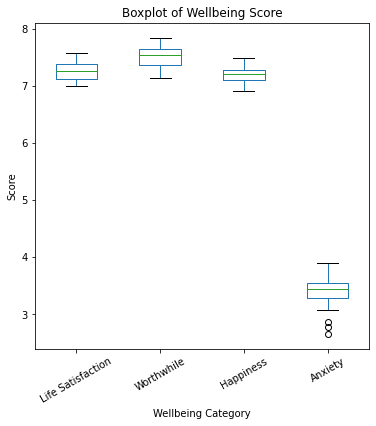

In [3]:
# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of Wellbeing Score')
plt.xlabel('Wellbeing Category')
plt.ylabel('Score')
plt_wellbeing = wellbeing.boxplot(wellbeing_cols + ['Anxiety'], grid = False, rot = 30, widths = 0.5)

Next, I will read in independent variables - NDVI, self-reported health, age and economic activity. Other variables added in to control for them, based on study done by ONS (these are those with at least moderate effect on well-being score) and availability of data.

Self-reported health and age are from 2011 census, but NDVI is collected in 2019. An alternative is to look at the land use data, but there seems to be a data gap between 2005 and 2018. 2018 data is also not very suitable as urban greenery is not a category on its own - they may be subsumed under other land uses. Should be ok to use NDVI data from 2019, since green cover may not change very fast as part of the built environment (??).

### NDVI

In [22]:
# Read NDVI
ndvi_cols = ['lb_code', 'lb_name', 'percent_green']
ndvi = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'green_cover_borough_summary_0.05.xlsx'),
                         sheet_name = 'borough_green_cover', usecols = ndvi_cols)

# Drop City of London
ndvi.drop(ndvi[ndvi.lb_code == 'City of London'].index, inplace = True)
ndvi.sort_values(by = ['lb_name'], ascending=True)
ndvi = ndvi.reset_index(drop = True)

# Change name of 'City of Westminster' to Westminster
ndvi.loc[ndvi[ndvi.lb_code == 'City of Westminster'].index, 'lb_code'] = 'Westminster'

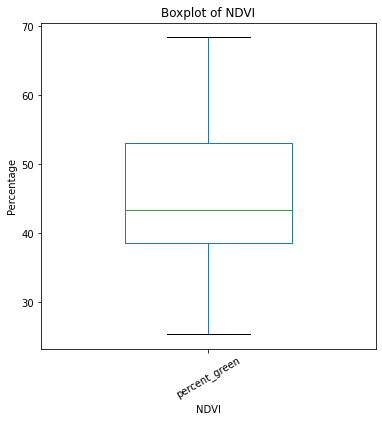

In [23]:
# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of NDVI')
plt.xlabel('NDVI')
plt.ylabel('Percentage')
plt_ndvi = ndvi.boxplot('percent_green', grid = False, rot = 30, widths = 0.5)

### Univariate regression

I will now perform regression on well-being scores against NDVI only to see if there is any significant relationship.

In [27]:
# Merge data
data_uni = pd.merge(wellbeing[['Area'] + wellbeing_cols], ndvi[['lb_code','percent_green']], 
                    left_on = 'Area', right_on = 'lb_code').drop('lb_code', axis = 1)

PERFORMING REGRESSION ON:LIFE SATISFACTION
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4.531
Date:                Wed, 05 Jan 2022   Prob (F-statistic):             0.0416
Time:                        23:25:52   Log-Likelihood:                 15.789
No. Observations:                  32   AIC:                            -27.58
Df Residuals:                      30   BIC:                            -24.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
con

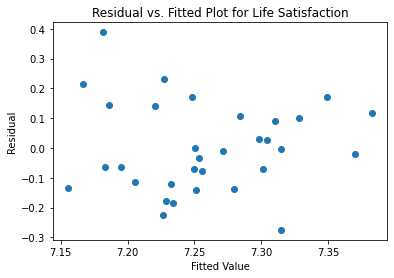



PERFORMING REGRESSION ON:WORTHWHILE
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     13.24
Date:                Wed, 05 Jan 2022   Prob (F-statistic):            0.00102
Time:                        23:25:52   Log-Likelihood:                 17.885
No. Observations:                  32   AIC:                            -31.77
Df Residuals:                      30   BIC:                            -28.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const   

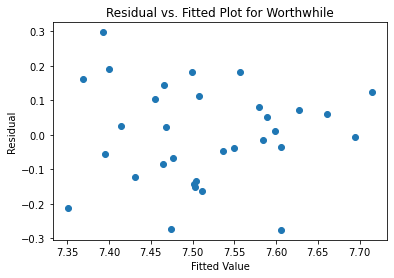



PERFORMING REGRESSION ON:HAPPINESS
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.822
Date:                Wed, 05 Jan 2022   Prob (F-statistic):             0.0599
Time:                        23:25:52   Log-Likelihood:                 20.486
No. Observations:                  32   AIC:                            -36.97
Df Residuals:                      30   BIC:                            -34.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const    

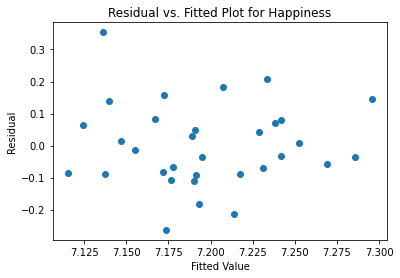

In [30]:
# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')
    
    # Perform regression
    reg_model = sm.OLS(endog=data_uni[cat], exog=sm.add_constant(data_uni.percent_green)).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

At 5% significance level, life satisfaction and worthwhile have positive and significant relationship with NDVI. Happiness has no significant relationship with NDVI.

Next, I will read in other variables that are known to have at least a moderate effect on well-being based on study done by ONS.

### Age and health

In [7]:
# Read self-reported health and age profile
age_cols = ['Age Structure (2011 Census);0-15;',
            'Age Structure (2011 Census);16-29;',
            'Age Structure (2011 Census);30-44;',
            'Age Structure (2011 Census);45-64;',
            'Age Structure (2011 Census);65+;']
health_cols = ['Health (2011 Census);Very good health;',
              'Health (2011 Census);Good health;',
              'Health (2011 Census);Fair health;',
              'Health (2011 Census);Bad health;',
              'Health (2011 Census);Very bad health;']
age_health = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'msoa-data.csv'),
                         usecols = ['Middle Super Output Area', 'MSOA Name',
                                    'Age Structure (2011 Census);All Ages;'] + age_cols + health_cols, 
                         low_memory = False, encoding = 'latin')

# Drop row on average for London and City of London
age_health.dropna(axis = 0, inplace = True)
age_health.drop(age_health[age_health['MSOA Name'] == 'City of London 001'].index, inplace = True)
age_health.reset_index(inplace = True)

# Change data type
age_health[age_cols] = age_health[age_cols].astype('int', copy = False)
age_health[health_cols] = age_health[health_cols].astype('int', copy = False)

# Drop numbers (last 4 characters) from MSOA name
for i in range(0, age_health.shape[0]):
               age_health.iloc[i,2] = age_health.iloc[i,2][:-4]

# Compute total number of respondents in MSOA
respondents = age_health.groupby('MSOA Name').agg({'Age Structure (2011 Census);All Ages;': np.sum}).reset_index()

# Compute number and percentage of respondents in each age group
age = age_health.groupby('MSOA Name').agg(dict.fromkeys(age_cols, np.sum)).reset_index()
age[age_cols] = age[age_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Compute number and percentage of respondents in each health category
health = age_health.groupby('MSOA Name').agg(dict.fromkeys(health_cols, np.sum)).reset_index()
health[health_cols] = health[health_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Rename columns for easy reference
age.rename({age_cols[0]: 'Age_0-15',
           age_cols[1]: 'Age_15-29',
           age_cols[2]: 'Age_30-44',
           age_cols[3]: 'Age_45-64',
           age_cols[4]: 'Age_65+'},
          axis = 1, inplace = True)
health.rename({health_cols[0]: 'Very_good',
               health_cols[1]: 'Good',
               health_cols[2]: 'Fair',
               health_cols[3]: 'Bad',
               health_cols[4]: 'Very_bad'},
              axis = 1, inplace = True)

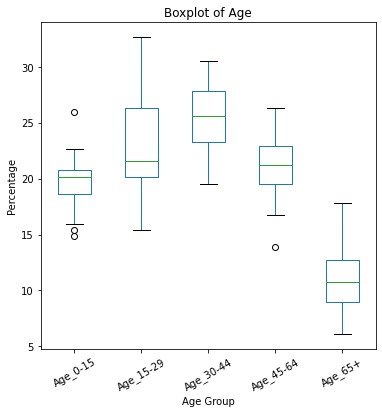

In [8]:
# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of Age')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt_age = age.boxplot(['Age_0-15', 'Age_15-29', 'Age_30-44', 'Age_45-64', 'Age_65+'], 
                       grid = False, rot = 30, widths = 0.5)

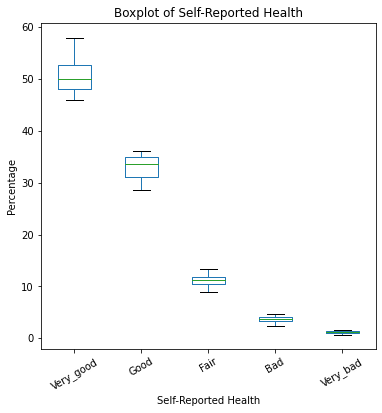

In [9]:
# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of Self-Reported Health')
plt.xlabel('Self-Reported Health')
plt.ylabel('Percentage')
plt_health = health.boxplot(['Very_good', 'Good', 'Fair', 'Bad', 'Very_bad'], 
                            grid = False, rot = 30, widths = 0.5)

### Economic activity

In [10]:
# Read economic inactivity and rename columns for easy reference
econ_cols = ['Code', 'Area', 'percent; Jan 2011-Dec 2011']
economic = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'economic-inactivity.csv'),
                         usecols = econ_cols, 
                         low_memory = False, encoding = 'latin')
economic.rename({econ_cols[2]: 'Econ_inactive'}, axis = 1, inplace = True)

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
economic.dropna(axis = 0, inplace = True)
economic = economic[economic['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
economic.drop(economic[economic.Area == 'City of London'].index, inplace = True)
economic = economic.reset_index(drop = True)

# Change data type
economic.Econ_inactive = economic.Econ_inactive.astype('float', copy = False)

In [11]:
# Read unemployment rate
unemployment_cols = ['Code', 'Area', 'Jan 2011-Dec 2011']
unemployment = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'mb-unemployment-rates.xlsx'), 
                             usecols = unemployment_cols, sheet_name = 'Rates')

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
unemployment.dropna(axis = 0, inplace = True)
unemployment = unemployment[unemployment['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
unemployment.drop(unemployment[unemployment.Area == 'City of London'].index, inplace = True)
unemployment = unemployment.reset_index(drop = True)

# Change data type
unemployment['Jan 2011-Dec 2011'] = unemployment['Jan 2011-Dec 2011'].astype('float', copy = False)

In [12]:
# Compute unemployment rate among economically active
economic['Unemployed'] = ((100 - economic.Econ_inactive)/100) * (unemployment['Jan 2011-Dec 2011']/100) * 100

# Compute employment rate among economically active
economic['Employed'] = 100 - economic.Econ_inactive - economic.Unemployed

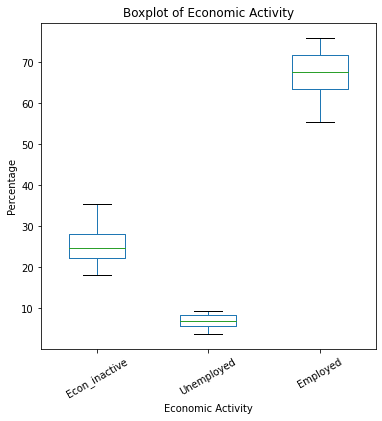

In [13]:
# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of Economic Activity')
plt.xlabel('Economic Activity')
plt.ylabel('Percentage')
plt_economic = economic.boxplot(['Econ_inactive', 'Unemployed', 'Employed'], 
                                grid = False, rot = 30, widths = 0.5)

### Multi-variate regression

In [31]:
# Merge all variables into a dataframe
data = data_uni.merge(health, left_on = 'Area', right_on = 'MSOA Name').drop('MSOA Name', axis = 1)
data = data.merge(age, left_on = 'Area', right_on = 'MSOA Name').drop('MSOA Name', axis = 1)
data = data.merge(economic[['Area','Econ_inactive','Unemployed','Employed']], on = 'Area')

Check for collinearity first

In [15]:
# Define function to drop variables using VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [32]:
# Drop collinear independent variables
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))

Dropping: Very_good
Dropping: Age_0-15
Dropping: Econ_inactive
Dropping: Bad
Dropping: Age_65+
Dropping: Fair
Dropping: Age_45-64


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Define functions to remove outliers

In [17]:
# Define function to extract outliers based on Tukey fences

def re_outliers(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences

    :param df: the pandas dataframe
    :param col_name: the column being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [area] that have been removed
    '''

    # Initialize
    df_clean = df
    outliers_areas = []
    temp_areas = []

    while True:
    
        # Compute quartiles and IQR
        q1 = df_clean[col_name].quantile(0.25)
        q3 = df_clean[col_name].quantile(0.75)
        iqr = q3 - q1
        # Compute Tukey fences
        lo_tukey = q1 - 1.5*iqr
        hi_tukey = q3 + 1.5*iqr
    
        # Locate the rows and areas that are outside the Tukey fences
        outliers_rows = df_clean.index[(df_clean[col_name] < lo_tukey) | (df_clean[col_name] > hi_tukey)]
        
        if len(outliers_rows) > 0:
            temp_areas = df_clean['Area'][outliers_rows].values.tolist()
            outliers_areas = list(set(outliers_areas + temp_areas))
            df_clean = df_clean.drop(index = outliers_rows)
        else:
            break
    
    # Return both cleaned df and outlier areas
    return df_clean, sorted(outliers_areas)

In [18]:
# Define function to remove outliers in paired samples

def re_outliers_paired(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences in paired fashion for multiple columns

    :param df: the pandas dataframe
    :param col_name: the list of column(s) being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [local authority area] that have been removed
    '''
    # initialize list to hold outlier areas
    outliers_area = []
    
    # For each column
    for col in col_name:
        # get outliers for the column
        temp_df, temp_outliers = re_outliers(df, col)
        # find all unique areas
        outliers_area = list(set(outliers_area + temp_outliers))
    
    outliers_area = sorted(outliers_area)
    
    # For all outlier areas
    df_clean = df
    for i in outliers_area:
        # Drop from df
        df_clean = df_clean.drop(df.index[df['Area'] == i])
    
    return df_clean, outliers_area

Perform regression

In [19]:
# Define function to perform backwards regression using p-value as selection criterion

def back_regress(df_dep, df_ind, thresh=0.05):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions
        if index_to_drop == 'const':
            reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
        else:
            reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
        
        # Find p-values for all variables
        df_pval = reg_model.pvalues
        #df_pval = pd.Series([reg_model.pvalues[i] for i in var], name='pvalue', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        if df_pval.max() > thresh:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_pval.index[df_pval == df_pval.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

PERFORMING REGRESSION ON:LIFE SATISFACTION
Dropping: Age_15-29
Dropping: Employed
Dropping: percent_green
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     16.52
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           5.88e-07
Time:                        23:11:47   Log-Likelihood:                 33.337
No. Observations:                  32   AIC:                            -56.67
Df Residuals:                      27   BIC:                            -49.35
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

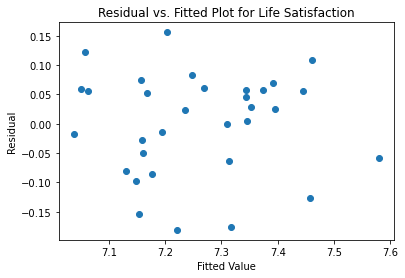



PERFORMING REGRESSION ON:WORTHWHILE
Dropping: Employed
Dropping: percent_green
Dropping: Unemployed
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     19.22
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           5.74e-07
Time:                        23:11:47   Log-Likelihood:                 29.928
No. Observations:                  32   AIC:                            -51.86
Df Residuals:                      28   BIC:                            -45.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

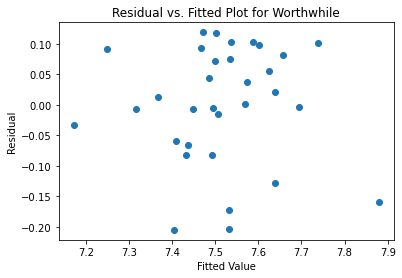



PERFORMING REGRESSION ON:HAPPINESS
Dropping: Very_bad
Dropping: Age_30-44
Dropping: Good
Dropping: Age_15-29
Dropping: Employed
Dropping: percent_green
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     16.41
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           0.000332
Time:                        23:11:47   Log-Likelihood:                 25.548
No. Observations:                  32   AIC:                            -47.10
Df Residuals:                      30   BIC:                            -44.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

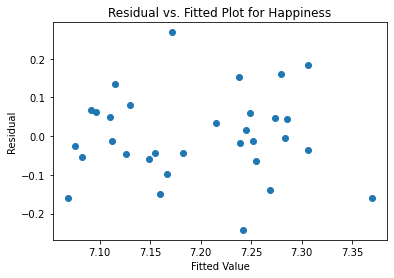

In [20]:
# Perform regression without removing outliers

for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Perform regression
    reg_model = back_regress(data[cat], ind_var_data)
    #reg_model = sm.OLS(endog=data[cat], exog=sm.add_constant(ind_var_data)).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
Dropping: Age_15-29
Dropping: Employed
Dropping: percent_green
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     16.52
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           5.88e-07
Time:                        23:11:47   Log-Likelihood:                 33.337
No. Observations:                  32   AIC:                            -56.67
Df Residuals:                      27   BIC:                            -49.35
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

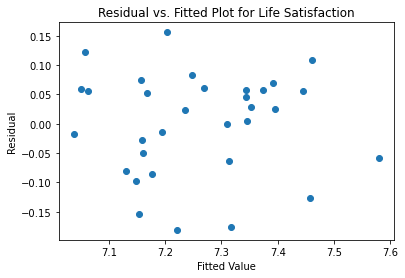



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
Dropping: Employed
Dropping: percent_green
Dropping: Unemployed
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     19.22
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           5.74e-07
Time:                        23:11:48   Log-Likelihood:                 29.928
No. Observations:                  32   AIC:                            -51.86
Df Residuals:                      28   BIC:                            -45.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.9

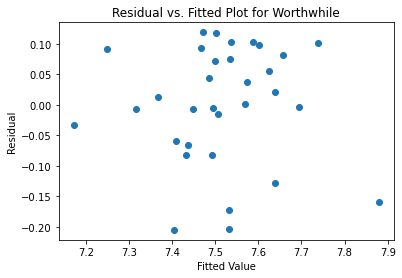



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
Dropping: Very_bad
Dropping: Age_30-44
Dropping: Good
Dropping: Age_15-29
Dropping: Employed
Dropping: percent_green
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     16.41
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           0.000332
Time:                        23:11:48   Log-Likelihood:                 25.548
No. Observations:                  32   AIC:                            -47.10
Df Residuals:                      30   BIC:                            -44.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t

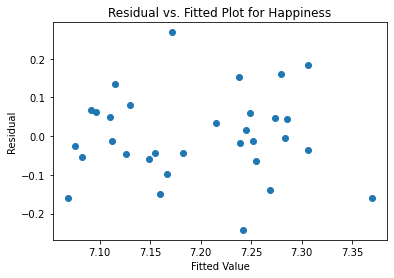

In [21]:
# Perform regression with outliers removed

for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    ind_var = ind_var_data.columns.tolist()
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

Once we add other variables, there is no longer any significant relationship between well-being scores and NDVI. Significance of relationship between well-being scores and NDVI may be due to associations with other predictors.

Justify looking for mediators???

## Regression 2: Mediators against NDVI

Four mediators from literature: Physical exercise, air quality and noise, self-reported stress, and social cohesion.

Due to lack of data, I am unable to look at social cohesion. Also, I will only be looking at objective air quality.

### Physical Activity

In [24]:
# Read in physical exercise (from 2012)
exercise = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'LSD21-APS-Physical-Activity-Levels.xlsx'),
                         sheet_name = '2012', usecols = ['GSS_Code', 'Region', 'Active'])

# Keep only data on London boroughs (Area Code starts with E09)
exercise = exercise[exercise['GSS_Code'].str.match(r'E09')].sort_values(by = ['GSS_Code'], ascending=True)
exercise = exercise.reset_index(drop = True)

# Convert 'Active' to percentage
exercise.Active = exercise.Active*100

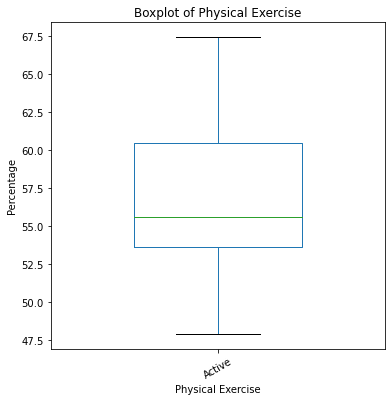

In [26]:
# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of Physical Exercise')
plt.xlabel('Physical Exercise')
plt.ylabel('Percentage')
plt_exercise = exercise.boxplot('Active', grid = False, rot = 30, widths = 0.5)

                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                 9.029e-05
Date:                Wed, 05 Jan 2022   Prob (F-statistic):              0.992
Time:                        23:39:10   Log-Likelihood:                -94.981
No. Observations:                  32   AIC:                             194.0
Df Residuals:                      30   BIC:                             196.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            56.6806      3.656     15.504

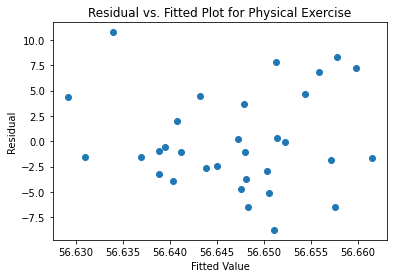

In [40]:
# Merge data
data_uni = pd.merge(exercise[['Region', 'Active']], ndvi[['lb_code','percent_green']], 
                    left_on = 'Region', right_on = 'lb_code').drop('lb_code', axis = 1)

# Regress physical activity against NDVI

reg_model = sm.OLS(endog=data_uni.Active, exog=sm.add_constant(data_uni.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Physical Exercise')
plt.show()

Physical activity not significantly correlated with NDVI

### Air Quality

In [85]:
# Read in air quality (from 2013)
air_quality = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'NO2_AnnualMean_2013_PopulationData.xlsx'),
                            sheet_name = 'Borough exceeding 40', skiprows = 4, 
                            usecols=['Borough Name', 'PopExc2013 %'])
air_quality['Borough Name'] = air_quality['Borough Name'].str.replace('&', 'and')

# Drop City of London
air_quality.drop(air_quality[air_quality['Borough Name'] == 'City of London'].index, inplace = True)
air_quality = air_quality.reset_index(drop = True)


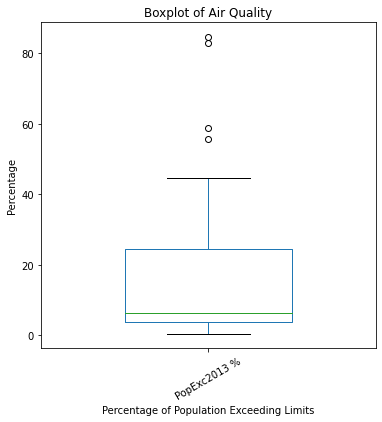

In [86]:
# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of Air Quality')
plt.xlabel('Percentage of Population Exceeding Limits')
plt.ylabel('Percentage')
plt_air = air_quality.boxplot('PopExc2013 %', grid = False, rot = 30, widths = 0.5)

                            OLS Regression Results                            
Dep. Variable:           PopExc2013 %   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     18.15
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000186
Time:                        00:06:56   Log-Likelihood:                -138.73
No. Observations:                  32   AIC:                             281.5
Df Residuals:                      30   BIC:                             284.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            78.0252     14.349      5.438

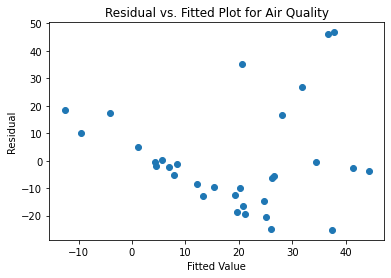

In [87]:
# Merge data
data_uni = pd.merge(air_quality, ndvi[['lb_code','percent_green']], 
                    left_on = 'Borough Name', right_on = 'lb_code').drop('lb_code', axis = 1)

# Regress air quality against NDVI without removing outliers

reg_model = sm.OLS(endog=data_uni['PopExc2013 %'], exog=sm.add_constant(data_uni.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Air Quality')
plt.show()

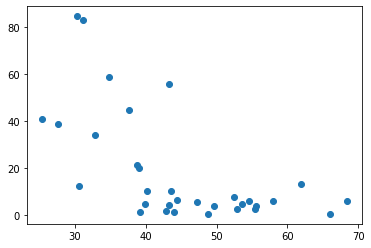

In [88]:
plt.scatter(ndvi.percent_green, air_quality['PopExc2013 %'])

Greenery has negative and significant relationship with air quality. However, there appears to be heteroskedasticity, likely because there are a lot of values near zero. Try taking log.

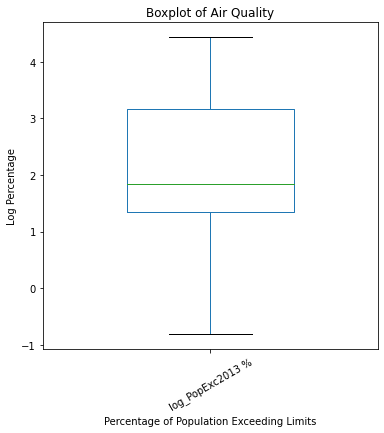

In [90]:
# Log
air_quality['log_PopExc2013 %'] = air_quality['PopExc2013 %'].apply(log)

# Box plot
plt.figure(figsize=(6, 6))
plt.title('Boxplot of Air Quality')
plt.xlabel('Percentage of Population Exceeding Limits')
plt.ylabel('Log Percentage')
plt_air = air_quality.boxplot('log_PopExc2013 %', grid = False, rot = 30, widths = 0.5)

                            OLS Regression Results                            
Dep. Variable:       log_PopExc2013 %   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     17.60
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000223
Time:                        00:08:06   Log-Likelihood:                -48.499
No. Observations:                  32   AIC:                             101.0
Df Residuals:                      30   BIC:                             103.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.5777      0.855      6.521

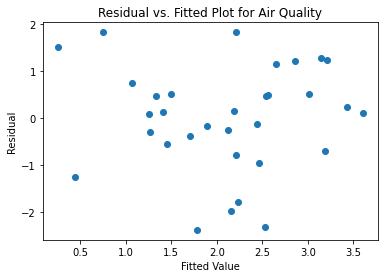

In [91]:
# Merge data
data_uni = pd.merge(air_quality, ndvi[['lb_code','percent_green']], 
                    left_on = 'Borough Name', right_on = 'lb_code').drop('lb_code', axis = 1)

# Regress air quality against NDVI without removing outliers

reg_model = sm.OLS(endog=data_uni['log_PopExc2013 %'], exog=sm.add_constant(data_uni.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Air Quality')
plt.show()

Negative and significant relationship between log pop exceeding limits and greenery. With homoskedasticity.

### Stress

                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7343
Date:                Thu, 06 Jan 2022   Prob (F-statistic):              0.398
Time:                        00:11:59   Log-Likelihood:                -5.9201
No. Observations:                  32   AIC:                             15.84
Df Residuals:                      30   BIC:                             18.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5964      0.226     15.907

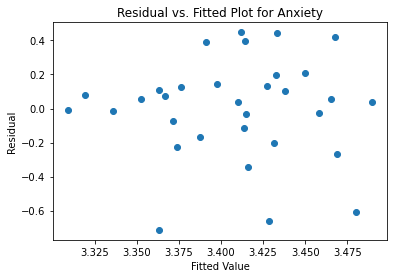

In [96]:
# Merge data
data_uni = pd.merge(wellbeing, ndvi[['lb_code','percent_green']], 
                    left_on = 'Area', right_on = 'lb_code').drop('lb_code', axis = 1)

# Regress physical activity against NDVI
reg_model = sm.OLS(endog=data_uni.Anxiety, exog=sm.add_constant(data_uni.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Anxiety')
plt.show()

Anxiety not significantly correlated with NDVI